# Q1,2,3_ErblinMarku_210762815_NLP_ECS763P_ASSIGNMENT_1_SEQUENCE_CLASSIFICATION
# Assignment 1: CRF sequence tagging for Movie Queries

**NOTEBOOK/CODE SUBMISSION:

In [1]:
conda install -c conda-forge sklearn-crfsuite

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - sklearn-crfsuite


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2021.10.8          |   py39hf3d152e_1         145 KB  conda-forge
    python-crfsuite-0.9.7      |   py39h45ac560_1         193 KB  conda-forge
    sklearn-crfsuite-0.3.6     |     pyh9f0ad1d_0          12 KB  conda-forge
    tabulate-0.8.9             |     pyhd8ed1ab_0          26 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         375 KB

The following NEW packages will be INSTALLED:

  python-crfsuite    conda-forge/linux-64::python-crfsuite-0.9.7-py39h45ac560_1
  sklearn-crfsuite   conda-forge/noarch::sklearn-crfsuite-0.3.6-pyh9f0ad1d_0
  tabulate           conda-forge/noarch::tabulate-0.8.9-pyhd8ed1ab_0

The fo

In [1]:
import os
import sys


from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report


from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [2]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [3]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [4]:
# have a look at an example to check if it is correct
print(raw_training_data[0], "\n")

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')] 



In [5]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

7816 instances
158823 words


In [6]:
def preProcess(example):
    preprocessed_example = example 
    return preprocessed_example

In [7]:
training_data = [preProcess(example) for example in raw_training_data]

In [8]:
# check the effect of pre-processing in two sentences
print(training_data[0],"\n")
print(training_data[1],"\n")

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')] 

[('liza', 'B-Actor'), ('minnelli', 'I-Actor'), ('and', 'O'), ('joel', 'B-Actor'), ('gray', 'I-Actor'), ('won', 'B-Award'), ('oscars', 'I-Award'), ('for', 'O'), ('their', 'O'), ('roles', 'O'), ('in', 'O'), ('this', 'O'), ('1972', 'B-Year'), ('movie', 'O'), ('that', 'B-Plot'), ('follows', 'I-Plot'), ('nightclub', 'I-Plot'), ('entertainers', 'I-Plot'), ('in', 'I-Plot'), ('berlin', 'I-Plot'), ('as', 'I-Plot'), ('the', 'I-Plot'), ('nazis', 'I-Plot'), ('come', 'I-Plot'), ('to', 'I-Plot'), ('power', 'I-Plot')] 



In [9]:
#imported the train_test_split from the sklearn data science library so I can use it to divide the data in two subsets used for training and testing
from sklearn.model_selection import train_test_split

""" - I used most train_test_split function when spliting the training data in two subsets.
    - Assigned the sizes of train data at 80% leaving the test data automatically at 20%.
    - Used only x_train and and x_test since our data is already in pairs of tuples format and I dont need to set data and 
        target attributes to the training_data.
    - random_state is set to 42(meaning of life :) ) because I want to see the changes in the training whenever i rerun the split"""

x_train, x_test =train_test_split(training_data, train_size=0.8, random_state=42)


#doing some tests so I can see if the split was succesful
#the outputs match the 80%-20% split.
#check also the first sentence of the train and test sets to see if there is any problem

print(len(training_data))
print(len(x_train))
print(len(x_test))
print(training_data[1],"\n")
print(x_train[1],"\n")
print(x_test[1],"\n")

7816
6252
1564
[('liza', 'B-Actor'), ('minnelli', 'I-Actor'), ('and', 'O'), ('joel', 'B-Actor'), ('gray', 'I-Actor'), ('won', 'B-Award'), ('oscars', 'I-Award'), ('for', 'O'), ('their', 'O'), ('roles', 'O'), ('in', 'O'), ('this', 'O'), ('1972', 'B-Year'), ('movie', 'O'), ('that', 'B-Plot'), ('follows', 'I-Plot'), ('nightclub', 'I-Plot'), ('entertainers', 'I-Plot'), ('in', 'I-Plot'), ('berlin', 'I-Plot'), ('as', 'I-Plot'), ('the', 'I-Plot'), ('nazis', 'I-Plot'), ('come', 'I-Plot'), ('to', 'I-Plot'), ('power', 'I-Plot')] 

[('what', 'O'), ('2012', 'B-Year'), ('movie', 'O'), ('features', 'O'), ('a', 'O'), ('struggling', 'B-Plot'), ('screenwriter', 'I-Plot'), ('who', 'I-Plot'), ('gets', 'I-Plot'), ('caught', 'I-Plot'), ('up', 'I-Plot'), ('in', 'I-Plot'), ('the', 'I-Plot'), ('los', 'I-Plot'), ('angeles', 'I-Plot'), ('criminal', 'I-Plot'), ('underworld', 'I-Plot')] 

[('yul', 'B-Actor'), ('brynner', 'I-Actor'), ('won', 'O'), ('an', 'O'), ('oscar', 'B-Award'), ('for', 'O'), ('his', 'O'), ('rol

In [10]:
_pattern = re.compile(r"\d")
def get_features(tokens, idx):

    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [11]:
#imported the python crfsuite and imported it here so we can use
import sklearn_crfsuite
TAGGER_PATH = "crf_nlu.tagger" 
ct = CRFTagger(feature_func=get_features)
#replace the training_data with x_train so we can train the 80% of the corpus
print("training tagger...")
ct.train(x_train, TAGGER_PATH)
print("training done")

training tagger...
training done


In [12]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [13]:
# an example from the corpus
example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies \n**"
print_tags(example)
# a novel, unseen example we've just made up
print_tags(" batman is the main character in batman begins \n**")
# another example
print_tags("the sound of music\n**")

steve       B-Actor
mcqueen     I-Actor
provided    O
a           B-Plot
thrilling   I-Plot
motorcycle  I-Plot
chase       I-Plot
in          I-Plot
this        I-Plot
greatest    I-Plot
of          I-Plot
all         I-Plot
ww          I-Plot
2           I-Plot
prison      I-Plot
escape      I-Plot
movies      I-Plot
**          I-Plot
batman      B-Plot
is          I-Plot
the         I-Plot
main        I-Plot
character   I-Plot
in          I-Plot
batman      I-Plot
begins      I-Plot
**          I-Plot
the         B-Plot
sound       I-Plot
of          I-Plot
music       I-Plot
**          I-Plot


In [14]:
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
# use the new test data created from the split of the training corpus, meaning we will test firs the held out data
print(len(x_test), "instances")
print(sum([len(sent) for sent in x_test]), "words")

1564 instances
31889 words


In [15]:
print("testing tagger...")
preds = []
y_test = []
for sent in x_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [16]:
# Output the classification report (which you should save each time for comparing your models)
classReport_afterSplit = classification_report(y_test, preds)
print(classReport_afterSplit)
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.87      0.88      0.87       967
         B-Award       0.79      0.60      0.68        62
B-Character_Name       0.76      0.24      0.36       217
      B-Director       0.79      0.69      0.73       357
         B-Genre       0.81      0.72      0.76       684
       B-Opinion       0.39      0.27      0.32       165
        B-Origin       0.52      0.33      0.40       157
          B-Plot       0.48      0.44      0.46      1321
         B-Quote       0.22      0.11      0.14        19
  B-Relationship       0.76      0.45      0.56       134
    B-Soundtrack       0.00      0.00      0.00        11
          B-Year       0.96      0.96      0.96       500
         I-Actor       0.87      0.87      0.87      1179
         I-Award       0.72      0.78      0.75       124
I-Character_Name       0.67      0.26      0.37       141
      I-Director       0.83      0.70      0.76       316
         I-Ge

In [17]:
###### 1 Question #######
#I saved the classification report as a dictionary(report_dict1) for easy of use for my Error analysis 1 & 2
import pandas as pd
report_dict1 = classification_report(y_test, preds, output_dict=True)
pd.DataFrame(report_dict1)

,B-Actor,B-Award,B-Character_Name,B-Director,B-Genre,B-Opinion,B-Origin,B-Plot,B-Quote,B-Relationship,...,I-Origin,I-Plot,I-Quote,I-Relationship,I-Soundtrack,I-Year,O,accuracy,macro avg,weighted avg
precision,0.871663,0.787234,0.761194,0.785256,0.807882,0.394737,0.520000,0.481023,0.222222,0.759494,...,0.627036,0.833541,0.238938,0.575893,0.0,0.700000,0.869790,0.820095,0.607187,0.815677
recall,0.877973,0.596774,0.235023,0.686275,0.719298,0.272727,0.331210,0.441332,0.105263,0.447761,...,0.620968,0.941346,0.281250,0.412141,0.0,0.717949,0.807432,0.820095,0.514070,0.820095
f1-score,0.874807,0.678899,0.359155,0.732436,0.761021,0.322581,0.404669,0.460324,0.142857,0.563380,...,0.623987,0.884170,0.258373,0.480447,0.0,0.708861,0.837451,0.820095,0.545683,0.814081
support,967.000000,62.000000,217.000000,357.000000,684.000000,165.000000,157.000000,1321.000000,19.000000,134.000000,...,620.000000,12804.000000,96.000000,313.000000,25.0,39.000000,11061.000000,0.820095,31889.000000,31889.000000


In [18]:
#Get the Precision values sorted for the analysis of False positives in Error Analysis 1, we sort and take the first 5 values.
pr= pd.DataFrame(report_dict1)
data1=pr.iloc[0,:]
sorted_precision = data1.sort_values()
sorted_precision.iloc[0:5]

B-Soundtrack    0.000000
I-Soundtrack    0.000000
I-Opinion       0.130000
B-Quote         0.222222
I-Quote         0.238938
Name: precision, dtype: float64

In [19]:
#looking at the top 5 categories with the lowest precision , 
#we have to deal with only 3 since the first 2 have 0 precision which means these categories dont have sentences
print("printing sentences")
categ=['B-Soundtrack','I-Soundtrack','B-Quote', 'I-Quote','I-Opinion']#use a list of our categories so we filter the others,'B-Quote', 

for sent in x_test:
    grt = [s[1] for s in sent]
    predic = [x[1] for x in ct.tag([s[0] for s in sent])]
    sentences = [s[0] for s in sent]
    #use n to limit the printing of sentences to only one time if more than one word happens to be a FP, which in our case happens a lot.
    n=2
    #I itereate and check for FP, which means the predicted tag found in one of our categories is different from than the tag in sent_true 
    for p, g, s in zip(predic,grt,sentences):
        if p not in categ:#focus only in the 3 categories we want
            continue
        if p != g:#check if it is FP
            n-=1
            if n>0:
                print(sentences)#First I print the sentence where the FP is found
            print('GroundTruth:{1}->Predicted:{2}-->"{0}"'.format(s,g,p)) #And then all the word found in the above sentence which are FP with their prediction, ground truth and the word
print("done")

printing sentences
['what', 'is', 'the', 'name', 'of', 'the', 'fifth', 'movie', 'in', 'the', 'series', 'about', 'how', 'you', 'ca', 'n', 't', 'cheat', 'death', 'or', 'fate']
GroundTruth:B-Plot->Predicted:B-Quote-->"how"
GroundTruth:I-Plot->Predicted:I-Quote-->"you"
GroundTruth:I-Plot->Predicted:I-Quote-->"ca"
GroundTruth:I-Plot->Predicted:I-Quote-->"n"
GroundTruth:I-Plot->Predicted:I-Quote-->"t"
GroundTruth:I-Plot->Predicted:I-Quote-->"cheat"
GroundTruth:I-Plot->Predicted:I-Quote-->"death"
GroundTruth:I-Plot->Predicted:I-Quote-->"or"
GroundTruth:I-Plot->Predicted:I-Quote-->"fate"
['what', 'critically', 'acclaimed', 'war', 'film', 'directed', 'by', 'steven', 'spielberg', 'was', 'upset', 'for', 'the', 'oscar', 'for', 'best', 'picture']
GroundTruth:B-Genre->Predicted:I-Opinion-->"war"
['what', '2011', 'gary', 'mckendry', 'thriller', 'features', 'jason', 'statham', 'clive', 'owen', 'robert', 'deniro', 'and', 'dominic', 'purcell']
GroundTruth:I-Actor->Predicted:I-Opinion-->"purcell"
['what'

In [20]:
#Get the recall values sorted for the analysis of False negatives in Error Analysis 2, we look at the 5 classes with lowest Recall values
rc= pd.DataFrame(report_dict1)
data2=rc.iloc[1,:]
sorted_recall = data2.sort_values()
sorted_recall.iloc[0:5]

I-Soundtrack        0.000000
B-Soundtrack        0.000000
B-Quote             0.105263
I-Opinion           0.117117
B-Character_Name    0.235023
Name: recall, dtype: float64

In [21]:
#looking at the top 5 categories with the lowest recall , 
#we have to deal with only 3 since the first 2 have 0 precision which means these categories dont have sentences
print("printing sentences for the FN...")
categ=['I-Soundtrack','B-Soundtrack','I-Opinion','B-Quote', 'B-Character_Name']#use a list of our categories so we filter the others
for sent in x_test:
    grt = [s[1] for s in sent]
    predic = [x[1] for x in ct.tag([s[0] for s in sent])]
    sentences = [s[0] for s in sent]
    n=2
    for g, p, s in zip(grt,predic,sentences):
        if g not in categ:#focus only in the categories we want
            continue
        if g != p:#check if it is FN
            n-=1
            if n>0:
                print(sentences)#First I print the sentence where the FN is found
            print('GroundTruth:{1}->Predicted:{2}-->"{0}"'.format(s,g,p))
print("done")

printing sentences for the FN...
['what', 'is', 'the', 'name', 'of', 'the', 'disney', 'classic', 'featuring', 'woodland', 'animals', 'and', 'a', 'bunny', 'named', 'thumper']
GroundTruth:B-Character_Name->Predicted:I-Plot-->"thumper"
['what', 'is', 'the', 'marvel', 'comic', 'movie', 'about', 'the', 'god', 'of', 'thunder', 'who', 'comes', 'to', 'earth', 'and', 'fights', 'his', 'brother', 'loki']
GroundTruth:B-Character_Name->Predicted:I-Plot-->"loki"
['what', 's', 'the', 'kubrick', 'film', 'set', 'in', 'the', 'future', 'and', 'involves', 'alex', 'and', 'his', 'band', 'of', 'thugs']
GroundTruth:B-Character_Name->Predicted:I-Plot-->"alex"
['a', 'clue', 'a', 'clue', 'my', 'kingdom', 'for', 'a', 'clue', 'about', 'which', 'movie', 'i', 'm', 'asking', 'about']
GroundTruth:B-Quote->Predicted:B-Plot-->"a"
['what', '2010', 'movie', 'finds', 'superhero', 'alter', 'ego', 'tony', 'stark', 'once', 'again', 'battling', 'evil', 'and', 'saving', 'the', 'day']
GroundTruth:B-Character_Name->Predicted:I-Pl

In [22]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    cm = confusion_matrix(y_test, preds,labels=labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

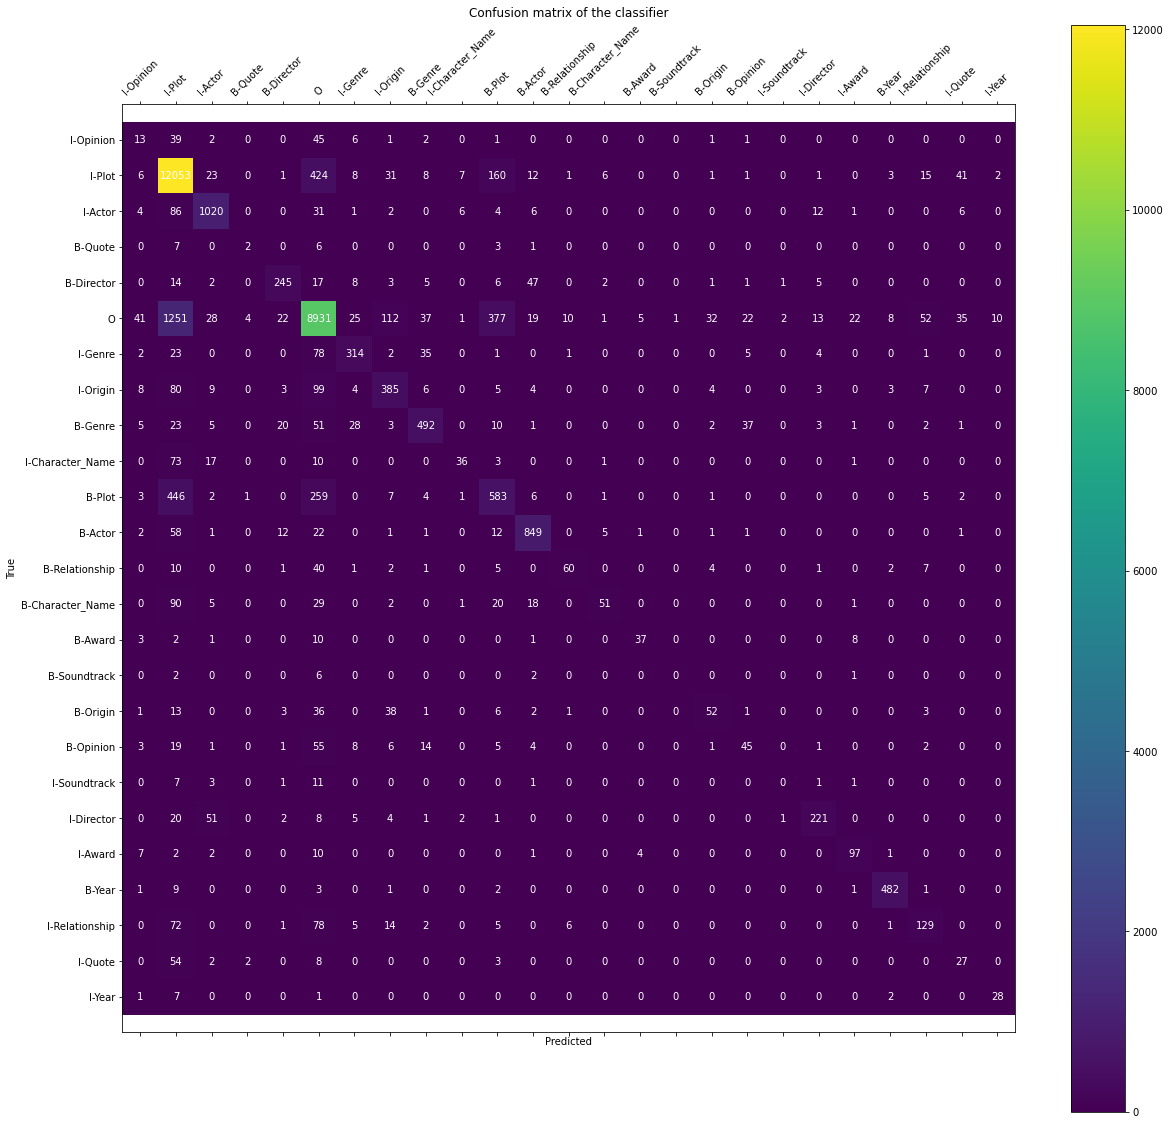

In [23]:
confusion_matrix_heatmap(y_test, preds)

In [ ]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [24]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [25]:
print_transition_weights(ct._tagger.info().transitions.items())

8.471514 B-Actor  -> I-Actor
8.090218 B-Plot   -> I-Plot
7.854099 B-Director -> I-Director
7.534275 B-Origin -> I-Origin
7.521228 I-Plot   -> I-Plot
7.359924 I-Quote  -> I-Quote
7.286801 B-Character_Name -> I-Character_Name
7.144042 I-Origin -> I-Origin
7.017604 B-Relationship -> I-Relationship
6.900127 B-Quote  -> I-Quote
6.813316 I-Relationship -> I-Relationship
6.700221 I-Soundtrack -> I-Soundtrack
6.659489 I-Opinion -> I-Opinion
6.530767 B-Genre  -> I-Genre
6.365595 B-Award  -> I-Award
6.267198 I-Award  -> I-Award
6.213906 B-Soundtrack -> I-Soundtrack
6.166130 B-Opinion -> I-Opinion
6.156259 I-Genre  -> I-Genre
6.129050 I-Actor  -> I-Actor
6.014470 I-Character_Name -> I-Character_Name
5.206706 I-Director -> I-Director
4.579554 I-Year   -> I-Year
3.845406 B-Year   -> I-Year
3.669106 B-Character_Name -> B-Plot
3.515401 O        -> O
3.309672 I-Character_Name -> B-Plot
3.226751 O        -> B-Plot
2.945648 B-Opinion -> B-Genre
2.938835 O        -> B-Character_Name
2.917959 B-Plot   -> 

In [40]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    n=5
    for (attr, label), weight in ranked_state_features:
        n-=1
        if n>0:
            print("%0.6f %-8s %s" % (weight, label, attr))

In [41]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

5.154417 B-Year   HAS_NUM
4.258232 I-Year   WORD_s
4.127231 B-Genre  WORD_animated
2.987438 B-Genre  WORD_thriller


# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.


# 2. Error analysis 1: False positives (5 marks)

Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


# 3. Error analysis 2: False negatives (5 marks)

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.
